## Read_plot_CDIP221

Script to pull CDIP data from THREDDS and do some analysis.
Initially based on the script here:
https://cdip.ucsd.edu/themes/media/docs/documents/html_pages/wave_rose.html

In [51]:
stn = '221'
startdate = "01/01/2015"
enddate = "01/01/2018"
# Import Libraries
import matplotlib as mpl
import netCDF4
import numpy as np
import numpy.ma as ma 
import matplotlib.pyplot as plt
import datetime
import time
import calendar
import pandas as pd

from itertools import groupby
%matplotlib inline

In [47]:
# URL - Archive THREDDS
#url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'
#url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/221p1/221p1_historic.nc'
#http://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/221p1/catalog.html

# local copy
url = '..\\2017_Sandwich_Nanopod\\221p1_historic.nc'
urlrt = '..\\2017_Sandwich_Nanopod\\221p1_rt.nc'

# Open URL as NetCDF file
nc = netCDF4.Dataset(url)
ncrt = netCDF4.Dataset(urlrt)

#Assign variable names to NetCDF objects
ncTime = np.concatenate([nc.variables['waveTime'][:],ncrt.variables['waveTime'][:]])
Tp = np.concatenate([nc.variables['waveTp'][:],ncrt.variables['waveTp'][:]])# Wave Frequency
Fq = np.concatenate([nc.variables['waveFrequency'][:],ncrt.variables['waveFrequency'][:]])# Wave Frequency
Hs = np.concatenate([nc.variables['waveHs'][:],ncrt.variables['waveHs'][:]]) # Wave Significant Height
Dp = np.concatenate([nc.variables['waveDp'][:],ncrt.variables['waveDp'][:]])  # Assign variable name - Wave Peak Direction
#buoyname = nc.variables['metaStationName'][:]
#buoytitle = " ".join(buoyname[:-40])
#print(buoyname)

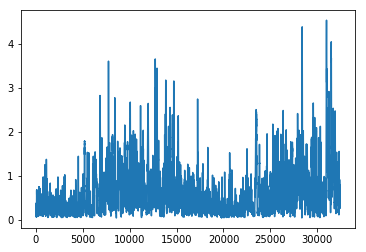

In [43]:
#Hs[nearIndex:endIndex]
plt.plot(Hs)

In [44]:
# Timestamp Conversions
# Define functions to convert between UNIX timestamps and human dates

# Find nearest value in numpy array
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Convert to unix timestamp
def getUnixTimestamp(humanTime,dateFormat):
    unixTimestamp = int(calendar.timegm(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unixTimestamp

# Convert to human readable timestamp
def getHumanTimestamp(unixTimestamp, dateFormat):
    humanTimestamp = datetime.datetime.utcfromtimestamp(int(unixTimestamp)).strftime(dateFormat)
    return humanTimestamp

#Convert user-set dates to UNIX timestamps
unixstart = getUnixTimestamp(startdate,"%m/%d/%Y") 
neareststart = find_nearest(ncTime, unixstart)  # Find the closest unix timestamp
nearIndex = np.where(ncTime==neareststart)[0][0]  # Grab the index number of found date

unixend = getUnixTimestamp(enddate,"%m/%d/%Y")
future = find_nearest(ncTime, unixend)  # Find the closest unix timestamp
endIndex = np.where(ncTime==future)[0][0]  # Grab the index number of found date

StartDate = getHumanTimestamp(ncTime[0],"%m/%d/%Y")
EndDate = getHumanTimestamp(ncTime[-1],"%m/%d/%Y")
print(StartDate, EndDate)

05/20/2016 04/02/2018


In [52]:

df=pd.DataFrame({'Hs':Hs, 'Tp':Tp, 'Dp':Dp})

In [46]:
#Calculate Hs frequencies - 16 degree bins
#Calculate total length of 'Wave Peak Direction (Dp)' variable

Dptot = len(Dp[:])
#Create array of total len of each of the 16 compass-direction bins (aka (number of Dp values in each 22.5-degree bin)/(total number of Dp values in time-chunk))

Dplens = []

dirstart = 11.25
dircount = 22.5
dirend = 348.75


for i in range(len(Dp)):
    Dpcut = (len([i for i, x in enumerate(Dp[:]) if (dirstart < x <= (dirstart+dircount))]))/float(Dptot)
    dirstart = dirstart+dircount
    Dplens.append(Dpcut)
    if dirstart == dirend:
        break
        
Dplens.append((len([i for i, x in enumerate(Dp[:]) if (348.75 < x or x <= (11.25))]))/float(Dptot))  # Manually append
                                                            # last bin (which crosses 360/0, and cannot be accounted for in for-loop)
#Grab maximum Dp length to set range of r-axis (frequency of occurences)
maxlen = max(Dplens)
lenround = round(maxlen,1)

#Call array of Hs values for specified time-chunk


#Index numbers of all Dp values in time-chunk array within each 22.5-degree bin
#Values of Hs objects that correspond to each Dp value (via array index number)
Dpidxs = []
Hsvals = []

idxstart = 11.25
idxcount = 22.5
idxend = 348.75

for idx in range(len(Dp)):
    idxvals = [idx for idx, x in enumerate(Dp[:]) if (idxstart < x <= (idxstart+idxcount))]
    Hsval = Hs[idxvals]
    idxstart = idxstart+idxcount
    Dpidxs.append(idxvals)
    Hsvals.append(Hsval)
    if idxstart == idxend:
        break
        
val15 = [idx for idx, x in enumerate(Dp[:]) if (348.75 < x or x <= (11.25))]
Hs15 = Hsc[val15]
Hsvals.append(Hs15)

# Hs sub-categories within degree-bins
# Separate Hs values within a degree-bin into height-specific categories

Hscats = []

catstart = 0
catstep = 3


for ibin2 in range(len(Hsvals)):
    catslist = []
    
    for val in Hsvals[ibin2]:
        if catstart <= val < (catstart+catstep):
            catval = 1 # Insert '1' for Hs values < 3, to avoid confusion with later step of inserting '0' as spaceholders for non-existent values
            catslist.append(catval)
        else:
            while catstart < val:
                catstart = catstart+catstep
            catval = catstart-3
            catslist.append(catval)

        catstart = 0
    Hscats.append(catslist)

# Sort all values within each Hs category ('Hscats' array) from smallest to largest value
# Create list of all sorted category values within each row, to be counted

Hscatsorttot = []

for row in range(len(Hscats)):
    sortrow = sorted(Hscats[row]) # sort all Hs category valus from smallest to largest
    Hscatsorttot.append(sortrow)
#Count number of objects in each category within each row (using 'Hscatsorttot)

Hscatscount = []
Hscatvals = []

for cat in range(len(Hscatsorttot)):
    catlen = [len(list(group)) for key, group in groupby(Hscatsorttot[cat])]
    catval = [key for key, group in groupby(Hscatsorttot[cat])]
    Hscatscount.append(catlen)
    Hscatvals.append(catval)

#Create master list of expected categorical bin values (e.g. bin 0-3, 3-6, etc., but replacing 0 with 1. Categories = 1,3,6,9,12,15...)
# Compare 'Hscatvals' list to master list
# Insert 0 values into missing locations in Hscatvals (presence of each expected length-3 categorical bin)

master = range(3,39,3) # Create list of values from 3-39, every 3 steps
master.insert(0,1) # add '1' as first value in the array

for val in range(len(Hscatvals)):
    for i in range(len(master)):
        if master[i] in Hscatvals[val]: # compare Hscatsvals value to master list. If values match up, move on to next element
            continue
        else:
            Hscatvals[val].insert(i,0) # If Hscatsval value does not match master list value, insert '0' placeholder value

NameError: name 'Hsc' is not defined

In [10]:
#Create copy of master list to set colorbar range
#Remove '1' bin category value and replace with '0' (to create '0-3 ft' range, rather than '1-3 ft' for colorbar). Does not change array values
In [18]:
master2 = master
master2.remove(1)
master2.insert(0,0)
Compare 'Hscatscount' list to Hscatvals

Insert 0 values into missing locations in Hscatscount (number of counts of each category instance)
In [19]:
for c in range(len(Hscatscount)):
    for e in range(len(Hscatvals[c])):
        if Hscatvals[c][e] == 0:
            Hscatscount[c].insert(e,0)
Category-specific array
Iterate over each element in each degree-bin list, across all 16 lists
In [20]:
catslist2 = []

    
for el in range(len(Hscatscount[2])):
    
    arr = []
    
    for count3 in range(len(Hscatscount)):
        var = Hscatscount[count3][el]
        arr.append(var)  
    catslist2.append(arr)
Call 'catslist' list as array, for plotting

In [21]:
catsarray = np.asarray(catslist2)
Divide each element in 'catsarray' by Dptot (total count-length for specified time-period) to create 'frequencies of occurrences' array for each 3-ft-range Hs bin

In [22]:
Dpfloat = float(Dptot)
catsfreq = catsarray/Dpfloat
Get number of instances of Hs range (e.g. 0-3 ft) across each 22.5-degree bin

Find length of row in Hscatscount
If length < total number of count-categories (e.g. len=2), then
In [23]:
bottom = np.cumsum(catsarray, axis=0) # Create array to call "bottom" array when plotting stacked barplot (below)
#Get number of instances of Hs range (e.g. 0-3 ft) across each 22.5-degree bin in 'Frequencies of Occurrencs' array

bottom2 = np.cumsum(catsfreq, axis=0)
Dp Directional bins
Create variable of 16 mid-point compass directions
Convert directions from degrees to radians

radconvert = np.pi/180

Dpdiralt = ([18,40.5,63,85.5,108,130.5,153,175.5,198,220.5,243,265.5,288,310.5,333,355.5]) # Specify radial locations to correspond to mid-barplots
Dpradalt = [d*radconvert for d in Dpdiralt]
Plot Wave Rose
Create Polar plot using Degree bings data ('Dpradalt') as thetas, and 'Dplens' as radii
Plot bottom row of barplot data using catsfreq[0] - 'Frequencies of Occurrence' array
Use for-loop to loop through successive rows of 'catsfreq' array
Option #2 - plot data as 'Hs Counts', rather than 'Frequencies of Occurrence'
In [26]:
# Create figure and specify size
fig = plt.figure(figsize=(10,10))

# Set radial/degree variables
thetas = Dpradalt
radii = Dplens[:]


# Specify barplot parameters
widths = 0.17
cmap = plt.get_cmap('gist_ncar',13)
cmaplist = [cmap(i2) for i2 in range(cmap.N)]


# Create subplot for barplot
ax = plt.subplot(111, polar=True) # Specify polar axes
ax.set_theta_direction(-1) # Reverse direction of degrees (CW)
ax.set_theta_zero_location("N") # Specify 0-degrees as North


## Plot Hs count data
# Plot bottom row of barplot data using 'Frequencies of Occurrence' array ('catsfreq'), then loop through successive rows of 'catsarray'
bars = ax.bar(thetas, catsfreq[0], width=widths, color=cmaplist[0])

for j in xrange(1, catsfreq.shape[0]):
    ax.bar(thetas, catsfreq[j], width=widths, color=cmaplist[j], bottom=bottom2[j-1])
    if j == ((catsfreq.shape[0])-2):
        break
        

# OPTION - Create array of radial length 0.03 * 16 bins, to fill center circle of polar plot
# radcirc = [0.03] * 16
# ax.fill(thetas,radcirc,fill=True,color='powderblue')


# Set plot titles
plt.suptitle(buoytitle + "\n" + "Stn. " + stn + " - Wave Rose", fontsize=30, y=1.12)
title(startdate + '-' + enddate, fontsize=24, y=1.08)


# Set degree gridlines to plot every 22.5 degrees
degrange = arange(0,360,22.5)
lines, labels = plt.thetagrids(degrange, labels=None, fontsize=14)


# Create colorbar
bounds = master2
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax2 = fig.add_axes([0.1, 0.025, 0.8, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, orientation='horizontal',boundaries=bounds, format='%1i')
cb.ax.tick_params(labelsize=14)
cb.set_label('Significant Wave Height (ft)', fontsize=20)

SyntaxError: invalid syntax (<ipython-input-10-07e3ed0d9a7b>, line 3)